In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/wingding

/content/drive/MyDrive/wingding


In [4]:
import pandas as pd
import numpy as np
from PIL import Image
import os
from tqdm import tqdm

def pad_image(image, target_size=(224, 224)):
    """Pad image to target size while maintaining aspect ratio"""
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Get current size
    width, height = image.size

    # Calculate padding
    aspect_ratio = width / height
    if aspect_ratio > 1:
        # Width is larger
        new_width = target_size[0]
        new_height = int(new_width / aspect_ratio)
    else:
        # Height is larger
        new_height = target_size[1]
        new_width = int(new_height * aspect_ratio)

    # Resize image maintaining aspect ratio
    image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)

    # Create new image with padding
    new_image = Image.new('RGB', target_size, (255, 255, 255))

    # Paste resized image in center
    paste_x = (target_size[0] - new_width) // 2
    paste_y = (target_size[1] - new_height) // 2
    new_image.paste(image, (paste_x, paste_y))

    return new_image

# Read the metadata
df = pd.read_csv('metadata.csv')

# Create output directory for processed images
processed_dir = 'processed_images'
os.makedirs(processed_dir, exist_ok=True)

# Process each image
new_paths = []
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing images"):
    # Load image
    img_path = row['image_path']
    img = Image.open(img_path)

    # Pad image
    processed_img = pad_image(img)

    # Save processed image
    new_path = os.path.join(processed_dir, f'processed_{os.path.basename(img_path)}')
    processed_img.save(new_path)
    new_paths.append(new_path)

# Update dataframe with new paths
df['processed_image_path'] = new_paths
df.to_csv('processed_metadata.csv', index=False)

print("Image preprocessing completed!")
print(f"Total images processed: {len(df)}")

Processing images: 100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]

Image preprocessing completed!
Total images processed: 1000


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the processed metadata
df = pd.read_csv('processed_metadata.csv')

# First split: train and temporary
train_df, temp_df = train_test_split(df, train_size=0.7, random_state=42)

# Second split: validation and test from temporary
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)

# Save splits to CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

print("Data split statistics:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Data split statistics:
Training samples: 700
Validation samples: 150
Test samples: 150


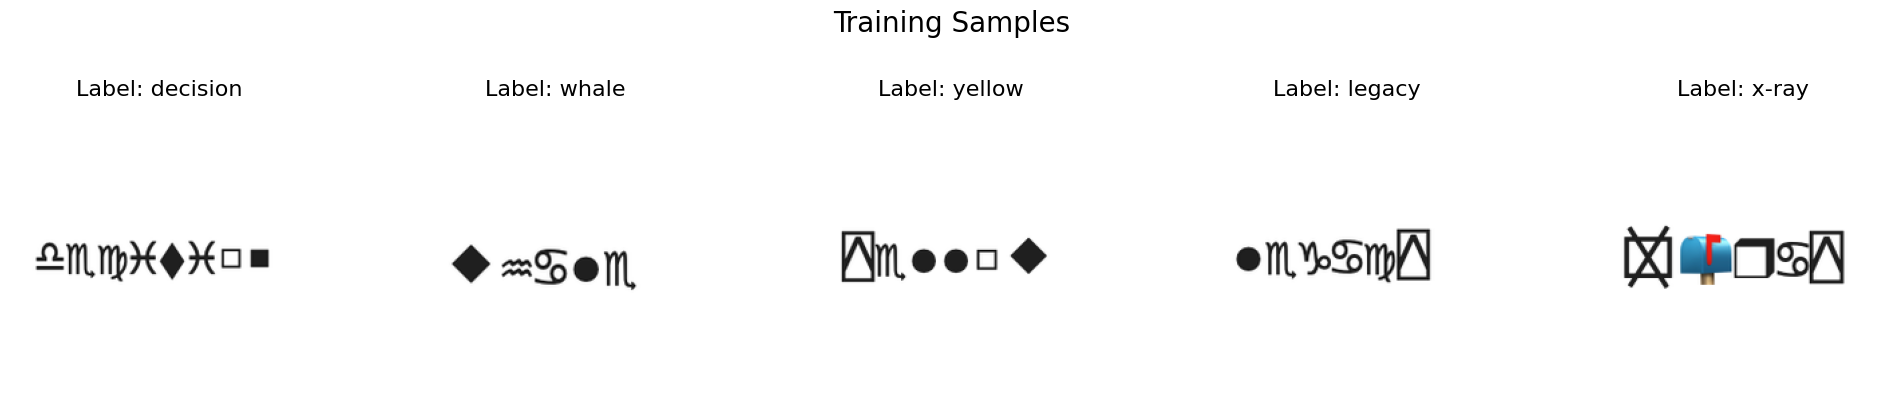

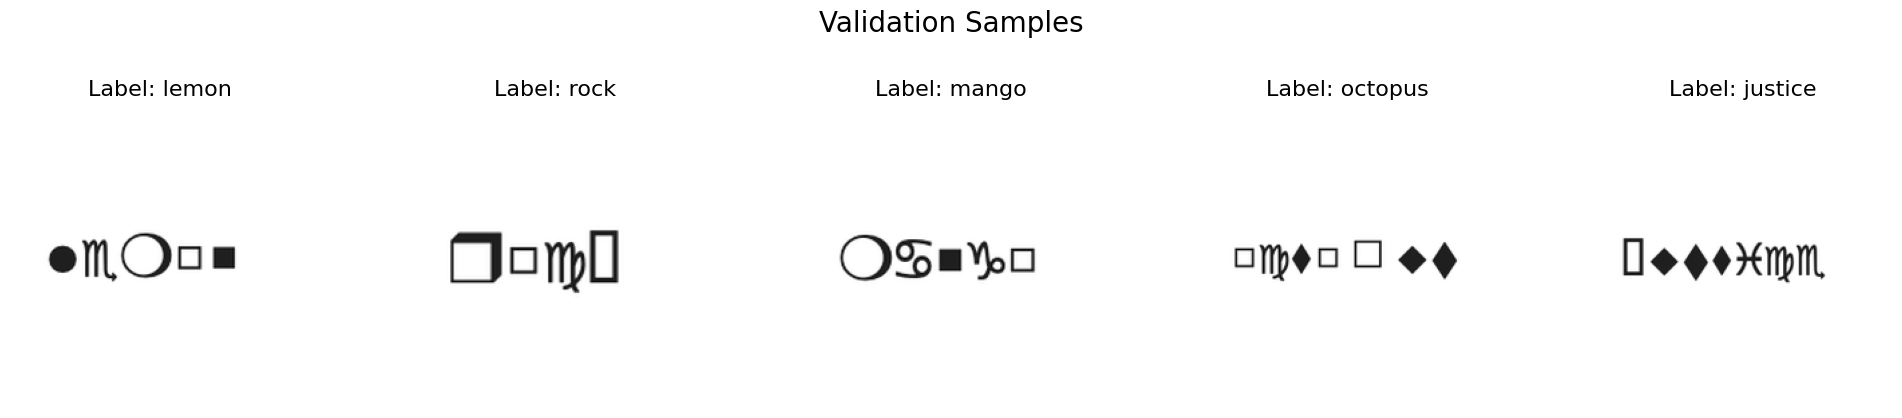

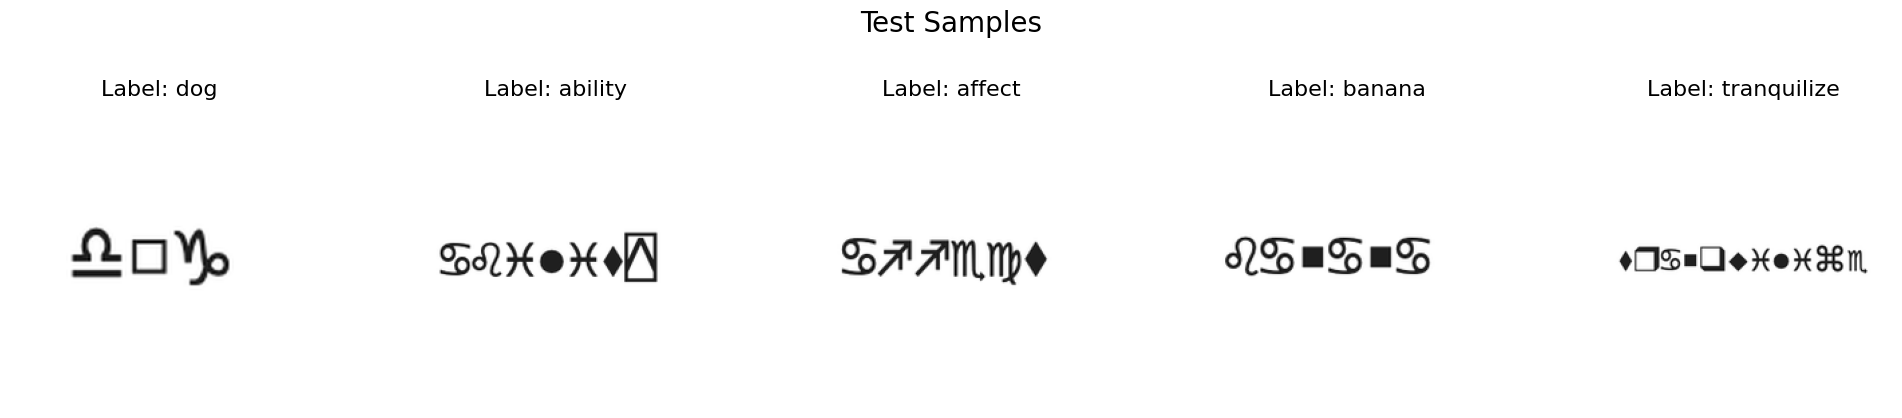

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def plot_samples(df, num_samples=5, title="Sample Images"):
    # Set larger font sizes
    plt.rcParams.update({
        'font.size': 14,          # Base font size
        'axes.titlesize': 16,     # Subplot title font size
        'figure.titlesize': 20    # Main title font size
    })

    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    fig.suptitle(title, fontsize=20, y=1.05)

    # Randomly sample images
    sample_df = df.sample(n=num_samples)

    for idx, (_, row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['processed_image_path'])
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {row['english_word_label']}", fontsize=16, pad=10)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Load splits
train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')
test_df = pd.read_csv('test.csv')

# Plot samples from each split
plot_samples(train_df, title="Training Samples")
plot_samples(val_df, title="Validation Samples")
plot_samples(test_df, title="Test Samples")

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import pandas as pd
from tqdm import tqdm

class WingdingsDataset(Dataset):
    def __init__(self, csv_path, processor, tokenizer):
        self.df = pd.read_csv(csv_path)
        self.processor = processor
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open(row['processed_image_path'])
        label = row['english_word_label']

        # Process image
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        # Process label
        encoding = self.tokenizer(
            label,
            padding="max_length",
            max_length=16,
            truncation=True,
            return_tensors="pt"
        )

        return {
            'pixel_values': pixel_values.squeeze(),
            'labels': encoding.input_ids.squeeze(),
            'text': label
        }

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Initialize models and tokenizers
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Create datasets
train_dataset = WingdingsDataset('train.csv', processor, tokenizer)
val_dataset = WingdingsDataset('val.csv', processor, tokenizer)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Setup training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

# Save the model
model.save_pretrained('wingdings_ocr_model')
print("\nTraining completed and model saved!")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang


Epoch 1/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Training Loss: 2.2776
Validation Loss: 1.0183

Epoch 2/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Training Loss: 1.0056
Validation Loss: 0.9170

Epoch 3/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Training Loss: 0.8794
Validation Loss: 0.8554

Epoch 4/20


Validating: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Training Loss: 0.7790
Validation Loss: 0.7877

Epoch 5/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Training Loss: 0.6789
Validation Loss: 0.7049

Epoch 6/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Training Loss: 0.5754
Validation Loss: 0.6443

Epoch 7/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Training Loss: 0.5066
Validation Loss: 0.6170

Epoch 8/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Training Loss: 0.4577
Validation Loss: 0.5926

Epoch 9/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Training Loss: 0.4015
Validation Loss: 0.5795

Epoch 10/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Training Loss: 0.3497
Validation Loss: 0.5491

Epoch 11/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Training Loss: 0.2754
Validation Loss: 0.5378

Epoch 12/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Training Loss: 0.2253
Validation Loss: 0.5357

Epoch 13/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Training Loss: 0.1793
Validation Loss: 0.5161

Epoch 14/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Training Loss: 0.1324
Validation Loss: 0.5281

Epoch 15/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Training Loss: 0.0978
Validation Loss: 0.5807

Epoch 16/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Training Loss: 0.0729
Validation Loss: 0.5316

Epoch 17/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Training Loss: 0.0471
Validation Loss: 0.5541

Epoch 18/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Training Loss: 0.0449
Validation Loss: 0.5524

Epoch 19/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Training Loss: 0.0398
Validation Loss: 0.5834

Epoch 20/20


Validating: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Training Loss: 0.0246
Validation Loss: 0.5970

Training completed and model saved!


In [13]:
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the trained model
model = VisionEncoderDecoderModel.from_pretrained('wingdings_ocr_model')
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create test dataset and dataloader
test_dataset = WingdingsDataset('test.csv', processor, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

predictions = []
ground_truth = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        pixel_values = batch['pixel_values'].to(device)
        texts = batch['text']

        outputs = model.generate(pixel_values)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predictions.extend(pred_texts)
        ground_truth.extend(texts)

# Calculate accuracy
accuracy = accuracy_score(ground_truth, predictions)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Display some example predictions
print("\nSample Predictions:")
for i in range(min(10, len(predictions))):
    print(f"True: {ground_truth[i]}")
    print(f"Pred: {predictions[i]}")
    print("---")

# Save results
results_df = pd.DataFrame({
    'True_Label': ground_truth,
    'Predicted_Label': predictions,
    'Correct': [t == p for t, p in zip(ground_truth, predictions)]
})
results_df.to_csv('test_results.csv', index=False)

print("\nDetailed results saved to 'test_results.csv'")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang


Test Accuracy: 0.6600

Sample Predictions:
True: desk
Pred: desk
---
True: whale
Pred: whale
---
True: affect
Pred: affect
---
True: aesthetic
Pred: odyssey
---
True: airport
Pred: airport
---
True: rose
Pred: rose
---
True: zebra
Pred: zebra
---
True: orange
Pred: orange
---
True: class
Pred: class
---
True: x-ray
Pred: x - ray
---

Detailed results saved to 'test_results.csv'


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.46.2"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_rang


Test Accuracy: 0.6600

Displaying sample predictions:


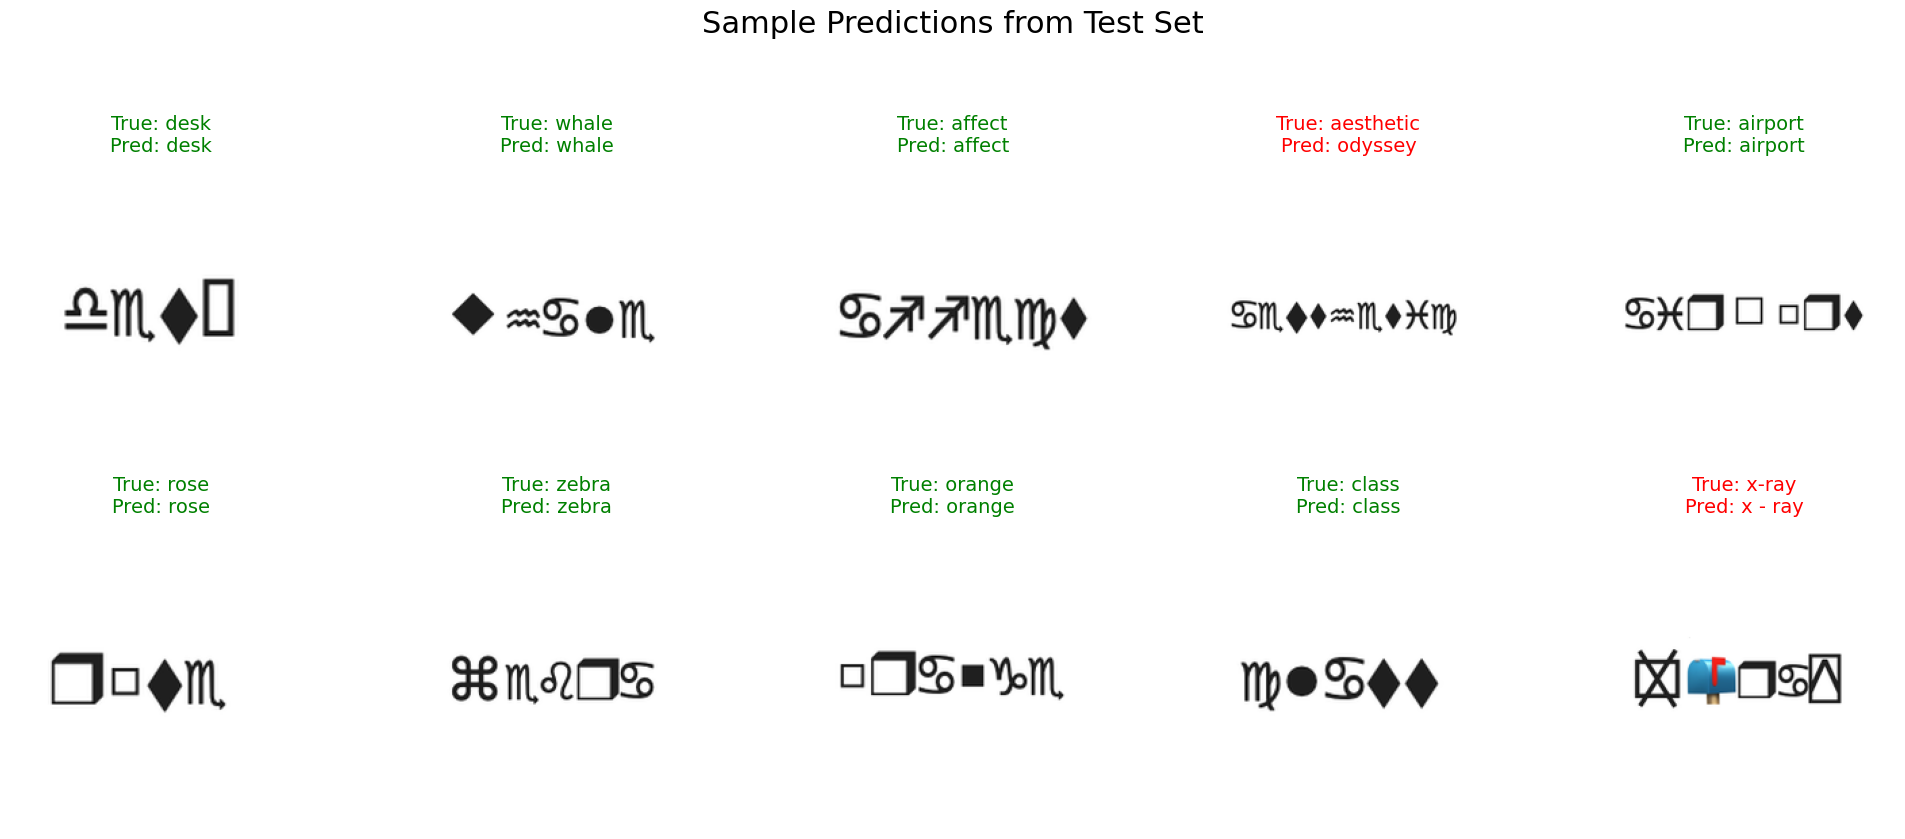

In [15]:
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

def plot_prediction_samples(image_paths, true_labels, pred_labels, num_samples=10):
    # Set figure size and font sizes
    plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'figure.titlesize': 22
    })

    # Calculate grid dimensions
    num_rows = 2
    num_cols = 5
    num_samples = min(num_samples, len(image_paths))

    # Create figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 8))
    fig.suptitle('Sample Predictions from Test Set', fontsize=22, y=1.05)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    for i in range(num_samples):
        ax = axes_flat[i]

        # Load and display image
        img = Image.open(image_paths[i])
        ax.imshow(img)

        # Create label text
        true_text = f"True: {true_labels[i]}"
        pred_text = f"Pred: {pred_labels[i]}"

        # Set color based on correctness
        color = 'green' if true_labels[i] == pred_labels[i] else 'red'

        # Add text above image
        ax.set_title(f"{true_text}\n{pred_text}",
                    fontsize=14,
                    color=color,
                    pad=10,
                    bbox=dict(facecolor='white',
                             alpha=0.8,
                             edgecolor='none',
                             pad=3))

        # Remove axes
        ax.axis('off')

    # Remove any empty subplots
    for i in range(num_samples, num_rows * num_cols):
        fig.delaxes(axes_flat[i])

    plt.tight_layout()
    plt.show()

# Load model and create dataset (previous code remains the same)
model = VisionEncoderDecoderModel.from_pretrained('wingdings_ocr_model')
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create test dataset and dataloader
test_dataset = WingdingsDataset('test.csv', processor, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=32)

# Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

predictions = []
ground_truth = []
image_paths = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        pixel_values = batch['pixel_values'].to(device)
        texts = batch['text']

        outputs = model.generate(pixel_values)
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predictions.extend(pred_texts)
        ground_truth.extend(texts)
        image_paths.extend([row['processed_image_path'] for _, row in test_dataset.df.iterrows()])

# Calculate and print accuracy
accuracy = accuracy_score(ground_truth, predictions)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Display sample predictions in grid
print("\nDisplaying sample predictions:")
plot_prediction_samples(image_paths, ground_truth, predictions)